In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from test_utils import summary   #print(tf.__version__)
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = ''
image_path = os.path.join(path, 'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/')
mask_path = os.path.join(path, 'C:/Users/erios/EM_Images/split_randomized_labels_ping/')
image_list_orig = os.listdir(image_path)                  # list within the folder
mask_list_orig = os.listdir(mask_path)                # list within the folder
image_list = [image_path+i for i in image_list_orig]      # full path and filename
mask_list = [mask_path+i for i in mask_list_orig]         # image_list and mask_list are class lists and have no dtype
image_filenames = tf.constant(image_list)   #tensor, dtype = string
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

In [4]:
for (img,lab) in dataset.take(100):
    print(f"image {img} label {lab}")

image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0000.png' label b'C:/Users/erios/EM_Images/split_randomized_labels_ping/0000Labeling.png'
image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0001.png' label b'C:/Users/erios/EM_Images/split_randomized_labels_ping/0001Labeling.png'
image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0002.png' label b'C:/Users/erios/EM_Images/split_randomized_labels_ping/0002Labeling.png'
image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0003.png' label b'C:/Users/erios/EM_Images/split_randomized_labels_ping/0003Labeling.png'
image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0004.png' label b'C:/Users/erios/EM_Images/split_randomized_labels_ping/0004Labeling.png'
image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0005.png' label b'C:/Users/erios/EM_Images/split_randomized_labels_ping/0005Labeling.png'
image b'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0006.

# Utilities

In [3]:
# utility for display. image tensors must be rank 3
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [4]:
# Preprocess, Data Augmentation
seed = (1, 2)
ran = tf.keras.layers.RandomContrast(0.4)       # RandomContrast of 0.4. Less than for granules.  Must check.
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=0, dtype=tf.dtypes.uint16)
    return img, mask

def preprocess(image, mask):
    global seed
    seed = (seed[0] + random.randint(0, 10000), seed[1] + random.randint(0, 10000))
    #changes the seed randomly
    input_image = tf.image.resize(image, (1024,1024), method='nearest')
    input_mask = tf.image.resize(mask, (1024,1024), method='nearest')
    input_image = tf.image.stateless_random_flip_left_right(input_image, seed)
    input_mask = tf.image.stateless_random_flip_left_right(input_mask, seed)
    input_image = tf.image.stateless_random_flip_up_down(input_image, seed)
    input_mask = tf.image.stateless_random_flip_up_down(input_mask, seed)
    input_image = ran(input_image)
    input_image = tf.image.random_brightness(input_image, 0.25)  # RandomBrightness 0.25.  Same as granules. Must check.
    return input_image, input_mask

In [5]:
# prediction from model outputs
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [6]:
def show_predictions(dataset=None, num=2):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_loc.predict(image)                           # model name changed to unet_loc
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(unet_loc.predict(sample_image[tf.newaxis, ...]))])

# Model components

In [7]:
def conv_block(inputs=None, n_filters=None, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=None):
    """
    Convolutional upsampling block
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(n_filters,3,strides=2,padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

In [9]:
def unet_model7(input_size=(1024, 1024, 1), n_filters=4, n_classes=7):
    """
    Function name changed to unet_model7
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock0 = conv_block(inputs, 4)
    cblock1 = conv_block(cblock0[0], 8)
    cblock2 = conv_block(cblock1[0], 16)
    cblock3 = conv_block(cblock2[0], 32)
    cblock4 = conv_block(cblock3[0], 64)
    cblock5 = conv_block(cblock4[0], 128)
    cblock6 = conv_block(cblock5[0], 256, 0.3) # Include a dropout_prob of 0.3 for this layer
    cblock7 = conv_block(cblock6[0], 512, 0.3, max_pooling=False) 
    # Expanding Path (decoding)
    ublock8 = upsampling_block(cblock7[0], cblock6[1], n_filters * 64)
    ublock9 = upsampling_block(ublock8, cblock5[1],  128)
    ublock10 = upsampling_block(ublock9, cblock4[1],  64)
    ublock11 = upsampling_block(ublock10, cblock3[1],  32)
    ublock12 = upsampling_block(ublock11, cblock2[1],  16)
    ublock13 = upsampling_block(ublock12, cblock1[1],  8)
    ublock14 = upsampling_block(ublock13, cblock0[1],  n_filters)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock14)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Model definition, compilation and loading of trained weights

In [10]:
# segmenter location's model is unet_loc
img_height = 1024
img_width = 1024
num_channels = 1
 
unet_loc = unet_model7((img_height, img_width, num_channels))
unet_loc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 4)        40        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1024, 1024, 4)        148       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 512, 512, 4)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [81]:
print(total_epochs)

120


In [117]:
unet_loc.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-4),    # ATTENTION NAdam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # metrics=['accuracy'])
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name= "Sparse Categorical Accuracy")])
 

In [82]:
unet_loc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # metrics=['accuracy'])
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name= "Sparse Categorical Accuracy")])
 

In [38]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
unet_loc.compile(optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name= "Sparse Categorical Accuracy")])
 

In [109]:
unet_loc.save_weights('./checkpoints/segmenter_locations1024_unet_loc_13')   #best weights from training so far
# loc_0   starting
# Loc_1   loss 1.416; Sp C Acc 0.4544   redone with _1 for keeping 0 as starter
# loc_2  loss 1.259; Sp C Acc 0.4542
# loc_3  Optimizer Nadam loc 1.16 Acc 0.496
# Loc_4  1 epoch after Loc_3 Optimizer Nadam Loc 1.197 Acc 0.5085
# Loc_5  5 e after 4 Nadam 1.198   0.5136
# L0c_6  5 e after 5 lr 4e-4      1.126  0.5197
# loc_7  20 e after 6 lr 4e-4     0.99   0.66
# Loc_8  20 e after 7 lr 3 e-4   0.84  0.75
# Loc_9  20 e after 8 lr 2 e-4   0.70   0.7937
# Loc_10  50 e after 9 lr 1.5 e-4 0.58  0.8117
# loc_11  back to Adam 1e-4 0.56,  0.8145,  ends at epoch 180
# loc_12  Nadam 1e-4, 250 epochs, 0.36  0.8597
# Loc_13  Loc_11 + 150 Nadam 1e-4, 0.40 0.8598

In [115]:
unet_loc.load_weights('./checkpoints/segmenter_locations1024_unet_loc_12')   #load initial weights

In [135]:
unet_loc.load_weights(checkpoint_filepath)

In [ ]:
#use this cell only if you don't want to shuffle images. good for generating predictions on the training set
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess) 
train_dataset = processed_image_ds.cache().batch(16)

# Model training

In [13]:
coarse_tuning_counter = 0
acc = [0.]  
loss = [0.]  

In [136]:
# main training
checkpoint_filepath = 'C:/Users/erios/checkpoints/checkpoint_unet_loc'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,  save_weights_only=True, monitor="Sparse Categorical Accuracy",
    mode='max', save_best_only=True)
image_ds = dataset.map(process_path)                       
processed_image_ds = image_ds.map(preprocess)              
BUFFER_SIZE = 100
BATCH_SIZE = 20
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
if coarse_tuning_counter == 0:
    initial_epochs = 1         # use in general 5
    total_epochs = initial_epochs
    history = unet_loc.fit(train_dataset, epochs=initial_epochs)
else:
    more_epochs = 250
    total_epochs =  total_epochs + more_epochs
    
    history = unet_loc.fit(train_dataset, epochs=total_epochs, 
                           initial_epoch=history.epoch[-1], callbacks=[model_checkpoint_callback])
coarse_tuning_counter += 1    
# update history
acc += history.history['Sparse Categorical Accuracy']
loss += history.history['loss']# plot evolution of accuracy and loss

Epoch 787/1037
5/5 [==============================] - 90s 17s/step - loss: 1.4635 - Sparse Categorical Accuracy: 0.5360
Epoch 788/1037
5/5 [==============================] - 83s 17s/step - loss: 1.1657 - Sparse Categorical Accuracy: 0.5745
Epoch 789/1037
5/5 [==============================] - 83s 17s/step - loss: 1.0802 - Sparse Categorical Accuracy: 0.6835
Epoch 790/1037
5/5 [==============================] - 83s 17s/step - loss: 0.8831 - Sparse Categorical Accuracy: 0.7378
Epoch 791/1037
5/5 [==============================] - 84s 17s/step - loss: 0.8596 - Sparse Categorical Accuracy: 0.7415
Epoch 792/1037
5/5 [==============================] - 83s 17s/step - loss: 0.9863 - Sparse Categorical Accuracy: 0.7097
Epoch 793/1037
5/5 [==============================] - 83s 17s/step - loss: 0.7653 - Sparse Categorical Accuracy: 0.7677
Epoch 794/1037
5/5 [==============================] - 83s 17s/step - loss: 0.7029 - Sparse Categorical Accuracy: 0.7882
Epoch 795/1037
5/5 [====================

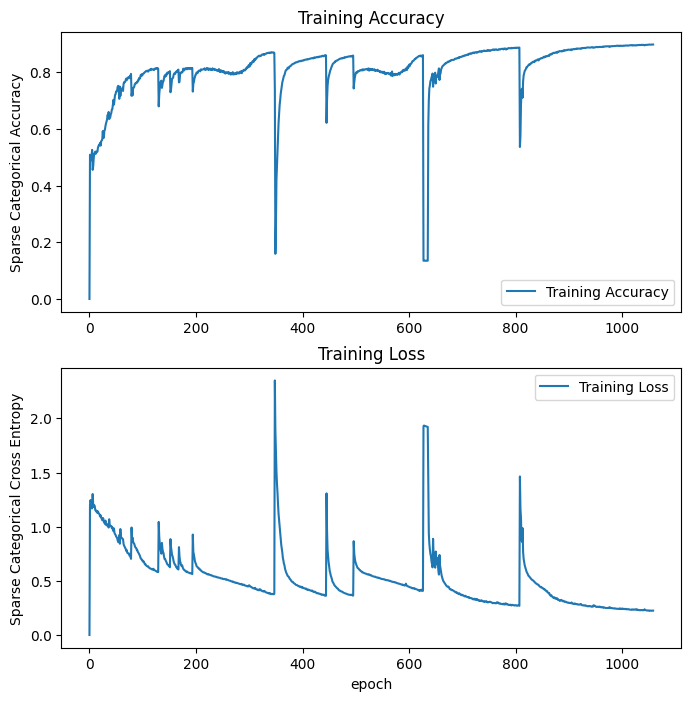

In [137]:
# update history
#acc += history.history['Sparse Categorical Accuracy']
#loss += history.history['loss']# plot evolution of accuracy and loss
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Sparse Categorical Accuracy')
plt.title('Training Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')

plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 3s 3s/step


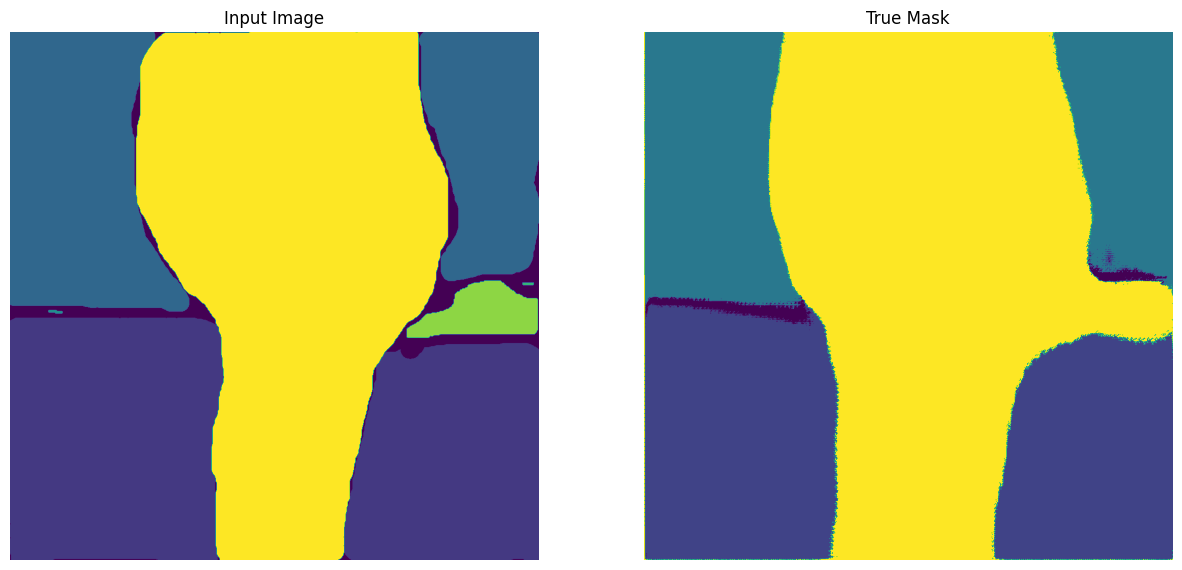

1/1 [==============================] - 3s 3s/step


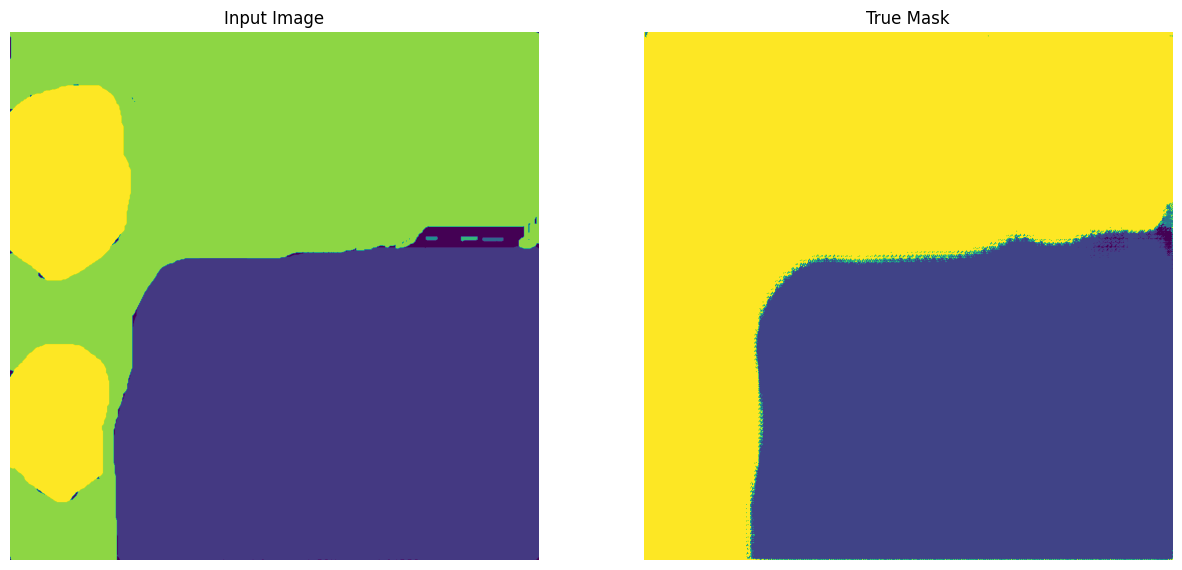

tf.Tensor(
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5], shape=(450,), dtype=uint16)


In [100]:
for image, mask in train_dataset.take(2):
            pred_mask = unet_loc.predict(image)                           # model name changed to unet_loc
            display([mask[0],create_mask(pred_mask)])
print(mask[0,40,50: 500,0])

In [102]:
predicted_mask = create_mask(pred_mask)
print(predicted_mask[740,50: 500,0])

tf.Tensor(
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 1 5 1 5 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1], shape=(450,), dtype=int64)


In [71]:
print(mask.shape)


(20, 1024, 1024, 1)


1/1 [==============================] - 3s 3s/step


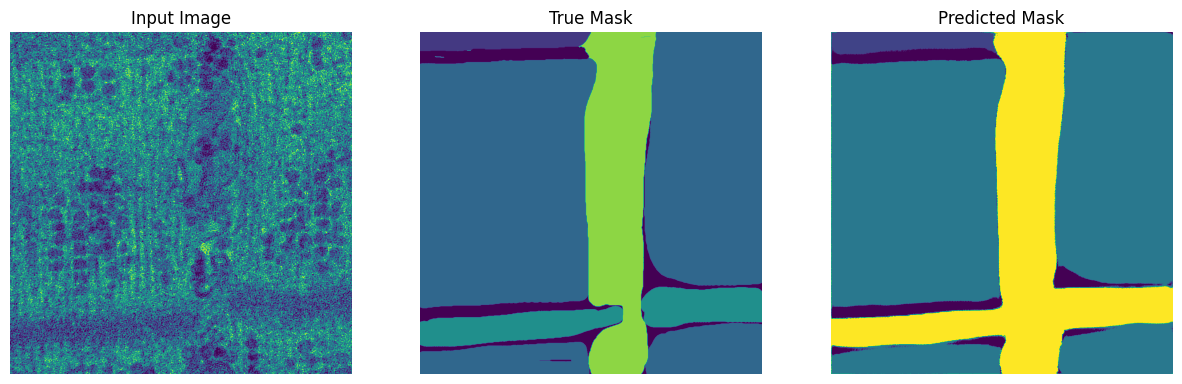

1/1 [==============================] - 3s 3s/step


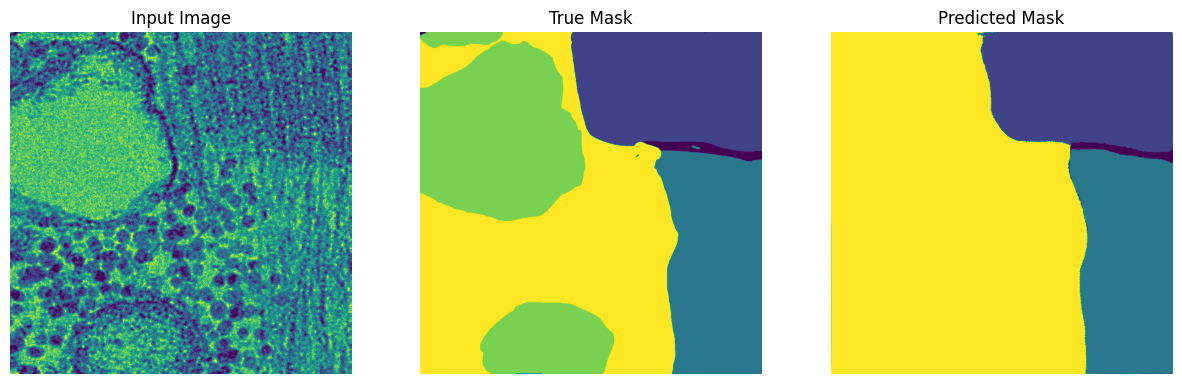

1/1 [==============================] - 4s 4s/step


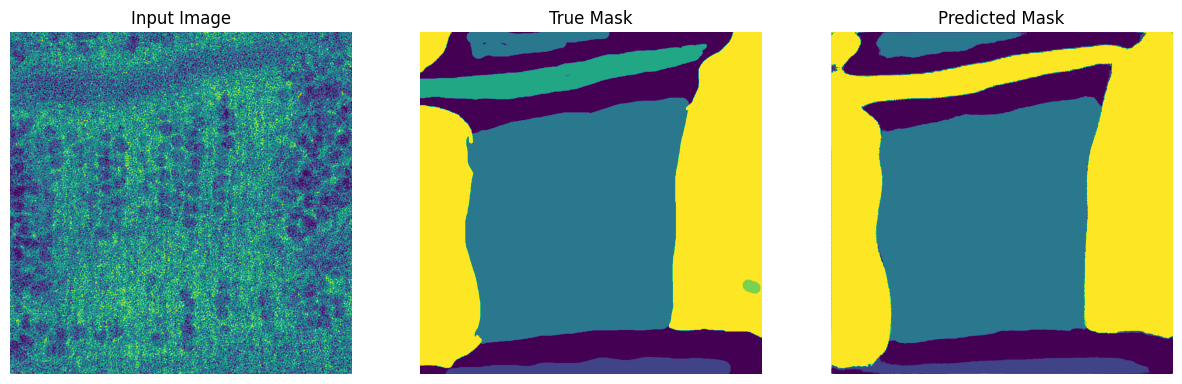

1/1 [==============================] - 3s 3s/step


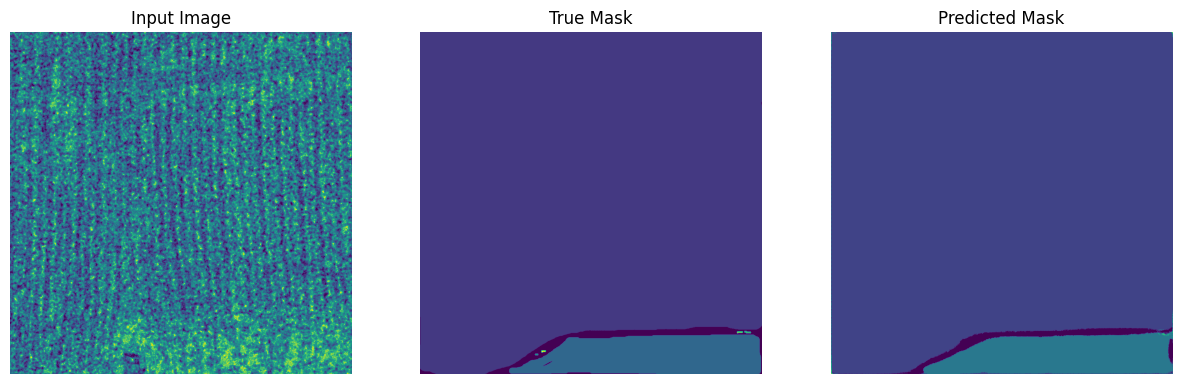

1/1 [==============================] - 3s 3s/step


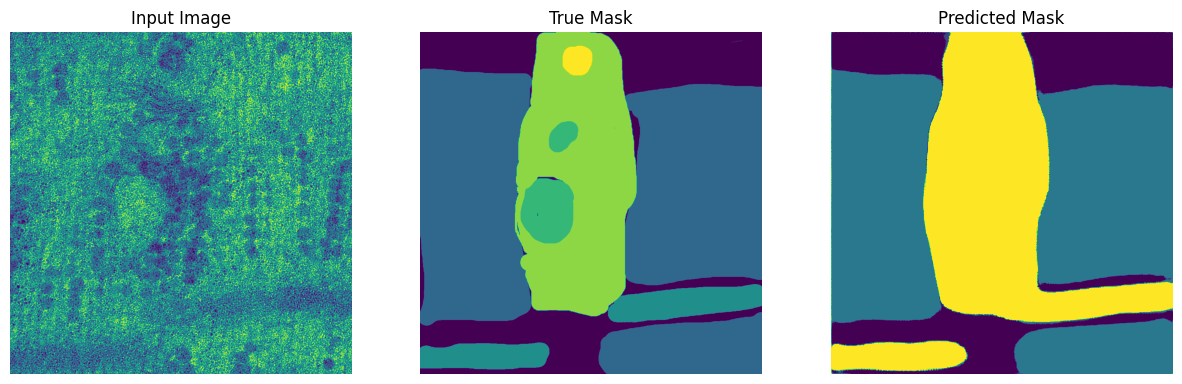

In [138]:
show_predictions(train_dataset, 6)

# Code for prediction on a "validation" or "test" set starts here.  Assumes existence of True Masks in the ...val_labels folder
first prepares data

In [ ]:
# "validation" is a misnomer as this is a "test" dataset --will not be used in training--  
path= ''
image_path_val = os.path.join(path, 'C:/Users/erios/EM_Images/split_random_granules_val/')
mask_path_val = os.path.join(path, 'C:/Users/erios/EM_Images/split_random_granules_val_labels/')
image_list_orig_val = os.listdir(image_path_val)   # a list of image file names
mask_list_orig_val = os.listdir(mask_path_val)
image_list_val = [image_path_val+i for i in image_list_orig_val]   # a list of image file names that includes the ful path
mask_list_val = [mask_path_val+i for i in mask_list_orig_val]   # print(image_list_val[0:1])
image_filenames_val = tf.constant(image_list_val)   #tensor, dtype = string
mask_filenames_val = tf.constant(mask_list_val)

dataset_val = tf.data.Dataset.from_tensor_slices((image_filenames_val, mask_filenames_val))   #a dataset of filenames

In [ ]:
# validation .  Preprocess does not include data augmentation 
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=0, dtype=tf.dtypes.uint16)
    return img, mask

def preprocess_val(image, mask):
    input_image = tf.image.resize(image, (1024,1024), method='nearest')
    input_mask = tf.image.resize(mask, (1024,1024), method='nearest')
    return input_image, input_mask

image_ds_val = dataset_val.map(process_path)
processed_image_ds_val = image_ds_val.map(preprocess_val)
#val_dataset is the validation dataset, batched and cached for application of prediction. Not to be confused with dataset_val
#val_dataset = processed_image_ds_val.cache().batch(7)
val_dataset = processed_image_ds_val.cache().batch(1)    #either way of batching works


In [ ]:
# validation, several checks that don't change the final output
# for image, mask in val_dataset.take(2):
#    print(image.shape)
#    print(mask.shape)

# print(image_list_orig_val[0:4])   #a check to show that the original order is unaltered
# print(mask_list_orig_val[0:4])

# show_predictions(processed_image_ds_val,1)
#show_predictions(val_dataset,1)   # see names in print above.  Original order is unaltered

# Prediction and output of images to Ping files

In [ ]:
# validation
probs_val = unet.predict(val_dataset)   #makes an np probability array  rank 4
n = probs_val.shape[0]                  # the number of images in the val dataset
probs1_val =  np.vsplit(probs_val, n)  #makes a list of n probability arrays (1024, 1024, 2)
pred_m_l_val= [np.zeros((1024,1024,2),dtype=float) for i in range(n)]   #initialization of a list of np.arrays
pred_val_acc_list= [0.0 for i in range(n)]
#print(len(pred_m_l_val))  #should be n
for i in range (n):
    pred_m_l_val[i] = create_mask((probs1_val[i]))      #list gets populated by prediction masks
#display([pred_m_l_val[4]])   #nice check
# now will write prediction masks to ping files, with same names as original image files in val folder
DIR = "C:/Users/erios/EM_Images/split_random_granules_val_preds/"
for i in range(n):
    name=DIR + str(image_list_orig_val[i])            # list of original image file names
    mask = tf.cast(pred_m_l_val[i],tf.uint16)         #  had to recast numpy prediction masks as uint16 (from int32)
    pred_png = tf.image.encode_png(mask)              #  otherwise, the encoder would not work
    with open(name, 'wb') as f:
        f.write(pred_png.numpy())                     #  works well

## Calculates accuracies for the entire val set and outputs them in a text file   

In [ ]:
m = tf.keras.metrics.Accuracy()
true_m_l_val= [np.zeros((1024,1024,2),dtype=float) for i in range(n)]   #initialization of a list of np.arrays true masks
count = 0
for image, mask in val_dataset:
        true_m_l_val[count] = mask[0]                                   # squeezes the first dimension; needed for accuracy calculation
        count=count+1
for i in range(n):
    m.update_state([pred_m_l_val[i]],[ true_m_l_val[i]])
    pred_val_acc_list[i] = m.result().numpy()                           # the accuracy function works in roundabout way
accuracy_out = DIR+"accuracies.txt"
f = open(accuracy_out, "w")
for i in range(n):
    f.write("\n"+str(i)+"    "+str(pred_val_acc_list[i])                # a two-column text output
f.close()

In [ ]:
print(pred_val_acc_list)

# End of predicting for validation/tests set
# Next cell makes a list of predicted masks for train set

In [ ]:
#probs = unet.predict(train_dataset)   #makes an np array (n_elements in train_dataset, 1024, 1024, 2)
probs1 =  np.vsplit(probs, 64)  #makes a list of arrays (1024, 1024, 2)
pred_m_l= [np.zeros((1024,1024,2),dtype=float) for i in range(64)]   #initialization of a list of np.arrays
for i in range (64):
    pred_m_l[i] = create_mask((probs1[i]))      #list gets populated
# The above list can be written to files as with the val set or used for calculation of metrics

# Studying Metrics

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state([sample_mask],[ predicted_mask])
m.result().numpy()

In [ ]:
mi = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])  IoU depends on the target class
mi.update_state([sample_mask],[ predicted_mask])
mi.result().numpy()

In [ ]:
mi = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
mi.update_state([sample_mask],[ predicted_mask])
mi.result().numpy()

# Augmentation demo

In [ ]:
filename = 'C:/Users/erios/EM_Images/split_randomized_labels_ping/0050Labeling.png'
file2 = 'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0050.png'
seed = (2, 3)
img = imageio.imread(filename)
imgt = tf.convert_to_tensor(img) 
imgte = tf.expand_dims(imgt,-1)
print(imgte.shape)
img2 = imageio.imread(file2)
imgt2 = tf.convert_to_tensor(img2) 
imgte2 = tf.expand_dims(imgt2,-1)
print(imgte2.shape)
augmented_image = tf.image.stateless_random_flip_left_right(imgte, (2, 3))
augmented_image2 = tf.image.stateless_random_flip_left_right(imgte2, (2, 3))
plt.imshow(augmented_image)
plt.imshow(augmented_image2)
ran = tf.keras.layers.RandomContrast(0.9)
display([ran(sample_image), sample_mask])

# Auxiliary

In [ ]:
# output to graphics file (ping) of single image
predicted_mask_ping = tf.image.encode_png(predicted_mask)
with open('D:/manuscripts and papers/Methods Manuscript Revision/test_predicted_mask.png', 'wb') as f:
  f.write(predicted_mask_ping.numpy())


In [ ]:
# make prediction for single image
pred = unet.predict(sample_image[tf.newaxis, ...])
#print(pred.shape)
predicted_mask=create_mask(pred) 
predicted_mask = tf.cast(predicted_mask, tf.uint16)